# Notebook for the Regression Model - Percentage Population at Home
## Last Updated: 10-06-2020

In [140]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
import json
import warnings
from os import listdir
from os.path import isfile,join
import datetime
import requests
from sklearn.metrics import r2_score, accuracy_score
import catboost
import matplotlib as mpl
import sys
sys.path.append('.')
from src.utils import collect_data

In [141]:
import importlib
importlib.reload(collect_data)

<module 'src.utils.collect_data' from 'C:\\Work\\projects\\mobility\\US_Mobility_BTS\\src\\utils\\collect_data.py'>

In [142]:
collect_datasets = collect_data.DataCollection()

In [184]:
county_spending_url = 'https://raw.githubusercontent.com/OpportunityInsights/EconomicTracker/main/data/Affinity%20-%20County%20-%20Daily.csv'

df_county_spending = pd.read_csv(county_spending_url, low_memory=False)

df_county_spending['date'] = df_county_spending['year'].astype(str) + '-' + \
                             df_county_spending['month'].astype(str) + '-' + \
                             df_county_spending['day'].astype(str)
df_county_spending.date = pd.to_datetime(df_county_spending.date, infer_datetime_format=True)
df_county_spending.countyfips = df_county_spending.countyfips.astype(int)
df_county_spending.countyfips = df_county_spending.countyfips.astype(str).str.zfill(5)
df_county_spending = df_county_spending.rename(columns={'countyfips': 'fips'})
null_fips_val_count = df_county_spending[df_county_spending.spend_all.isna()]['fips'].value_counts()
high_null_fips = null_fips_val_count[null_fips_val_count>50].index
df_county_spending = df_county_spending[~df_county_spending['fips'].isin(high_null_fips)]
df_county_spending = df_county_spending.reset_index()
df_county_spending['spend_all'] = df_county_spending['spend_all'].fillna(0)
return df_county_spending

,index,year,month,day,fips,spend_all,provisional,date
0,0,2020,1,1,01001,0.0000,0,2020-01-01
1,1,2020,1,1,01003,0.0000,0,2020-01-01
2,2,2020,1,1,01009,0.0000,0,2020-01-01
3,3,2020,1,1,01015,0.0000,0,2020-01-01
4,4,2020,1,1,01019,0.0000,0,2020-01-01
...,...,...,...,...,...,...,...,...
453175,457816,2020,10,11,56035,-0.1510,1,2020-10-11
453176,457817,2020,10,11,56037,-0.2420,1,2020-10-11
453177,457818,2020,10,11,56039,-0.2050,1,2020-10-11
453178,457819,2020,10,11,56041,0.0589,1,2020-10-11


In [175]:
df_county_spending = df_county_spending[~df_county_spending['fips'].isin()]


year               0
month              0
day                0
fips               0
spend_all      24561
provisional        0
date               0
dtype: int64

In [180]:
null_fips_val_count = df_county_spending[df_county_spending.spend_all.isna()]['fips'].value_counts()

30011    273
30101    273
29151    273
29051    273
29043    273
        ... 
51143     12
37189     12
41059     12
36053     12
54049     12
Name: fips, Length: 1677, dtype: int64

In [144]:
df_mobility = collect_datasets.get_mobility_data()
df_county_spending = collect_datasets.get_spend_data()
df_covid = collect_datasets.combine_covid_data()
df_weather = collect_datasets.combine_weather(df_mobility,df_covid)
df_county = collect_datasets.combined_county_data()

AttributeError: Can only use .str accessor with string values!

In [124]:
def get_model_df(df_weather, df_mob,df_covid,df_demographics,covid=False):
    df_mob = df_mob.dropna()
    covid_date = datetime.datetime.strptime('2020-03-15', '%Y-%m-%d')
    if covid:
        df_mob_covid = pd.merge(left = df_mob, right = df_covid, on = ['fips', 'date'], how='inner')
        df_mob_covid = df_mob_covid[df_mob_covid.date >covid_date]
    else:
        df_mob_covid = df_mob[df_mob.date < covid_date]
        
    df_mob_covid_weather = pd.merge(left = df_mob_covid, right = df_weather, on =['date', 'fips'])
    df_all = pd.merge(left = df_mob_covid_weather.drop(columns=['State Postal Code', 'Level']), 
                      right = df_demographics, on = ['fips'])
    df_all['party'] =df_all['party'].fillna('republican')
    return df_all

In [134]:
df_mobility.date.max()

Timestamp('2020-10-03 00:00:00')

In [139]:
df_mobility[(df_mobility.fips == '01001') &(df_mobility.date > '2020-09-26')]

,Level,date,State Postal Code,fips,Population Staying at Home,Population Not Staying at Home,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,...,Number of Trips 250-500,Number of Trips >=500,weekday,weekend,mobility_per_trip,mobility_per_person,pct_stay_home,trips_per_person,Max_Trip_Type,pct_not_home
0,County,2020-10-03,AL,01001,10920.0,44681.0,159472.0,32341.0,38888.0,25231.0,...,172.0,21.0,Saturday,Weekend,10.526616,30.191912,19.639935,2.868150,Number of Trips 1-3,80.360065
1,County,2020-10-02,AL,01001,9857.0,45744.0,179089.0,40822.0,43890.0,21287.0,...,295.0,22.0,Friday,Weekday,10.103923,32.544406,17.728098,3.220967,Number of Trips 1-3,82.271902
2,County,2020-10-01,AL,01001,9073.0,46528.0,169030.0,33225.0,40020.0,24366.0,...,339.0,14.0,Thursday,Weekday,11.152408,33.903914,16.318052,3.040053,Number of Trips 1-3,83.681948
3,County,2020-09-30,AL,01001,11044.0,44557.0,163850.0,30293.0,40399.0,21267.0,...,51.0,15.0,Wednesday,Weekday,11.036619,32.523696,19.862952,2.946889,Number of Trips 1-3,80.137048
4,County,2020-09-29,AL,01001,9830.0,45771.0,159342.0,32922.0,34968.0,21025.0,...,92.0,12.0,Tuesday,Weekday,11.129486,31.895011,17.679538,2.865812,Number of Trips 1-3,82.320462
5,County,2020-09-28,AL,01001,9638.0,45963.0,159346.0,33473.0,39108.0,21617.0,...,189.0,18.0,Monday,Weekday,9.908033,28.395272,17.334221,2.865884,Number of Trips 1-3,82.665779
6,County,2020-09-27,AL,01001,11799.0,43802.0,154087.0,29708.0,37864.0,22766.0,...,442.0,21.0,Sunday,Weekend,10.579257,29.318286,21.220841,2.771299,Number of Trips 1-3,78.779159
1995887,County,2020-09-27,AL,01001,11799.0,43802.0,154087.0,29708.0,37864.0,22766.0,...,442.0,21.0,Sunday,Weekend,10.579257,29.318286,21.220841,2.771299,Number of Trips 1-3,78.779159
1997460,County,2020-09-28,AL,01001,9638.0,45963.0,159346.0,33473.0,39108.0,21617.0,...,189.0,18.0,Monday,Weekday,9.908033,28.395272,17.334221,2.865884,Number of Trips 1-3,82.665779
2002217,County,2020-09-29,AL,01001,9830.0,45771.0,159342.0,32922.0,34968.0,21025.0,...,92.0,12.0,Tuesday,Weekday,11.129486,31.895011,17.679538,2.865812,Number of Trips 1-3,82.320462


In [132]:
x = df_mobility[df_mobility.date > '2020-09-26'].groupby(['fips']).size()


fips
01001    28
01003    28
01005    28
01007    28
01009    28
         ..
56037    28
56039    28
56041    28
56043    28
56045    28
Length: 3138, dtype: int64

In [131]:
df_mobility.fips.nunique()

3141

In [125]:
def run_model(df,name,target_var,remove_col_list,task_type='GPU',max_depth= 6):
    
    remove_cols = ['date','fips','COUNTY','YEAR','NAME_E' ] + remove_col_list
    
    df_final = df.drop(columns=remove_cols)
    df_final = df_final.dropna()
    X =df_final.drop(columns=[target_var])
    y =df_final[[target_var]]
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
    cat_index = [X.columns.get_loc("STATE"),X.columns.get_loc("weekday"),
                 X.columns.get_loc("weekend"),X.columns.get_loc("party")]
    cb_model = catboost.CatBoostRegressor(task_type=task_type, n_estimators=1000, eval_metric='RMSE',
                                      max_depth=max_depth,devices='0',learning_rate=0.35,
                                          verbose=200,cat_features=cat_index)
    cb_model.fit(X_train,y_train)
    y_pred_cb = cb_model.predict(X_test)
    print(np.round(r2_score(y_test,y_pred_cb),2))
    test = y_test.values.flatten()
    plt.scatter(y_test,(test-y_pred_cb)*100/test,s=2)
    plt.yscale('symlog')
    plt.xscale('log')
    plt.xlabel('y_true')
    plt.ylabel('Error (%)')
    plt.ylim(-500,500)
    plt.show()
    df_cb_feat_imp =  pd.DataFrame(cb_model.feature_importances_, X_train.columns,columns=[name +'_Covid_Feature_Importance'])
    return df_cb_feat_imp,y_test,y_pred_cb


<AxesSubplot:>

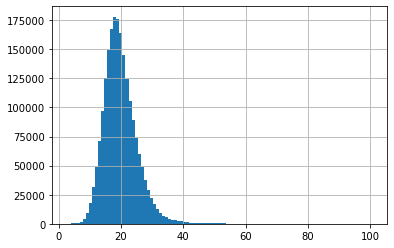

In [127]:
df_mobility['pct_stay_home'].hist(bins=100)

0:	learn: 4.5614861	total: 628ms	remaining: 10m 27s
200:	learn: 1.7722746	total: 1m 34s	remaining: 6m 16s
400:	learn: 1.6661083	total: 3m 11s	remaining: 4m 45s
600:	learn: 1.6000294	total: 4m 47s	remaining: 3m 10s
800:	learn: 1.5517836	total: 6m 22s	remaining: 1m 35s
999:	learn: 1.5119476	total: 7m 57s	remaining: 0us
0.9


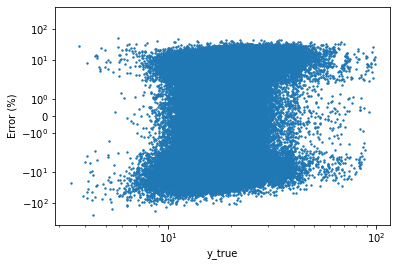

,Pre_Covid_Feature_Importance
Travel Time to Work_5 to 9 minutes,5.852872
STATE,5.446186
Means of Transportation to Work_Walked,5.342111
"Means of Transportation to Work_Car, truck, or van",5.167987
Travel Time to Work_45 to 59 minutes,3.680722
Race_Black or African American alone,2.759530
Means of Transportation to Work_Public transportation (excluding taxicab),2.571259
Travel Time to Work_Less than 5 minutes,2.499504
Gross Rent as a Percentage of Household Income in the Past 12 Months_Total,2.334353
Gross Rent as a Percentage of Household Income in the Past 12 Months_Not computed,2.144587


In [126]:
target_var = 'pct_stay_home'
keep_cols = ['weekday','weekend'] + [target_var]
df_mob_train_pre = get_model_df(df_weather, df_mobility,df_covid,df_county)
remove_col_list = [col for col in df_mobility.columns if col in df_mob_train_pre and col not in keep_cols]

df_mob_pre_feat_imp,y_test,y_pred_cb = run_model(df_mob_train_pre,'Pre', target_var,remove_col_list,task_type='CPU',max_depth = 8)
df_mob_pre_feat_imp.sort_values('Pre_Covid_Feature_Importance',ascending=False)[:20]

Total Rows Test Dataset 271708 ||| Records with over 200% error 0


,error_pct,Count
STATE,,
Delaware,-1.070713,241
Oklahoma,-0.806316,6664
Kansas,-0.716028,8869
District of Columbia,-0.709767,108
Florida,-0.661783,5773
Arkansas,-0.634922,6660
Pennsylvania,-0.615409,5884
South Carolina,-0.578461,3954
Louisiana,-0.571819,5575


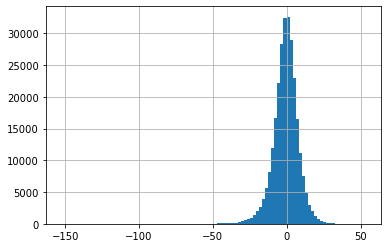

In [12]:
pd.options.mode.chained_assignment = None
y_test['pred']= y_pred_cb
y_test['error_pct'] = (y_test[target_var] - y_test.pred)*100/y_test[target_var]
test_data = df_mob_train_pre.loc[y_test.index]
test_data['error_pct'] = y_test['error_pct']
y_test.error_pct[abs(y_test.error_pct)<200].hist(bins=100)
print('Total Rows Test Dataset',len(y_test),'||| Records with over 200% error',
      len(y_test[abs(y_test.error_pct)>200]))
pd.concat([test_data.groupby(['STATE'])['error_pct'].median(),
           test_data.groupby(['STATE'])['error_pct'].count().rename('Count')], 
           axis=1).sort_values('error_pct')

In [20]:
df_mob_train_covid = get_model_df(df_weather, df_mobility,df_covid,df_county,covid=True)
remove_col_list_COVID = [col for col in df_mobility.columns if col in df_mob_train and col not in keep_cols]
remove_col_list_COVID.extend(['Lat','Lng'])
df_mob_covid_feat_imp,y_test,y_pred_cb = run_model(df_mob_train_covid,'Post', target_var,remove_col_list_COVID,task_type='CPU',max_depth = 8)
df_mob_covid_feat_imp.sort_values('Post_Covid_Feature_Importance',ascending=False)[:25]

KeyboardInterrupt: 

In [ ]:
y_test['pred'] = y_pred_cb
y_test['error_pct'] = (y_test[target_var] - y_test.pred)*100/y_test[target_var]
test_data = df_mob_train_covid.loc[y_test.index]
test_data['error_pct'] = y_test['error_pct']
y_test.error_pct[abs(y_test.error_pct)<200].hist(bins=100)
print('Total Rows Test Dataset',len(y_test),'||| Records with over 200% error',
      len(y_test[abs(y_test.error_pct)>200]))
pd.concat([test_data.groupby(['STATE'])['error_pct'].median(),
           test_data.groupby(['STATE'])['error_pct'].count().rename('Count')], 
           axis=1).sort_values('error_pct')